<a href="https://colab.research.google.com/github/MrCamilo5/tesis_ingindustrial/blob/main/mkporttesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade cvxpy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
datos=pd.read_csv('/content/drive/MyDrive/Tesis/muestras/PRECIO.csv', index_col=[0], parse_dates=True)

In [ ]:
datos.describe().round(2)

,NUTRESA,ISA,GRUPOSURA,BCOLOMBIA,PROMIGAS,GEB,TERPEL,BVC,ECOPETROL,BOGOTA
count,286.00,286.00,286.00,286.00,286.00,286.00,286.00,286.00,286.00,286.00
mean,22441.01,20913.95,22236.99,28225.07,7347.45,2445.63,7965.38,10940.73,2202.48,72253.81
std,1563.29,3056.35,3126.21,4749.63,467.78,172.30,880.36,1171.36,334.57,7741.28
min,17000.00,11800.00,15000.00,17700.00,6500.00,1760.00,6300.00,8100.00,1380.00,58000.00
25%,21455.00,18820.00,20445.00,24992.50,6990.00,2350.00,7480.00,10602.50,2006.25,66915.00
50%,22620.00,20545.00,21685.00,26780.00,7300.00,2460.00,7997.50,11000.00,2171.00,71000.00
75%,23595.00,23090.00,23215.00,30700.00,7793.75,2561.00,8317.50,11880.00,2303.75,78400.00
max,25300.00,29250.00,33600.00,44700.00,8400.00,2840.00,10860.00,12740.00,3460.00,89740.00


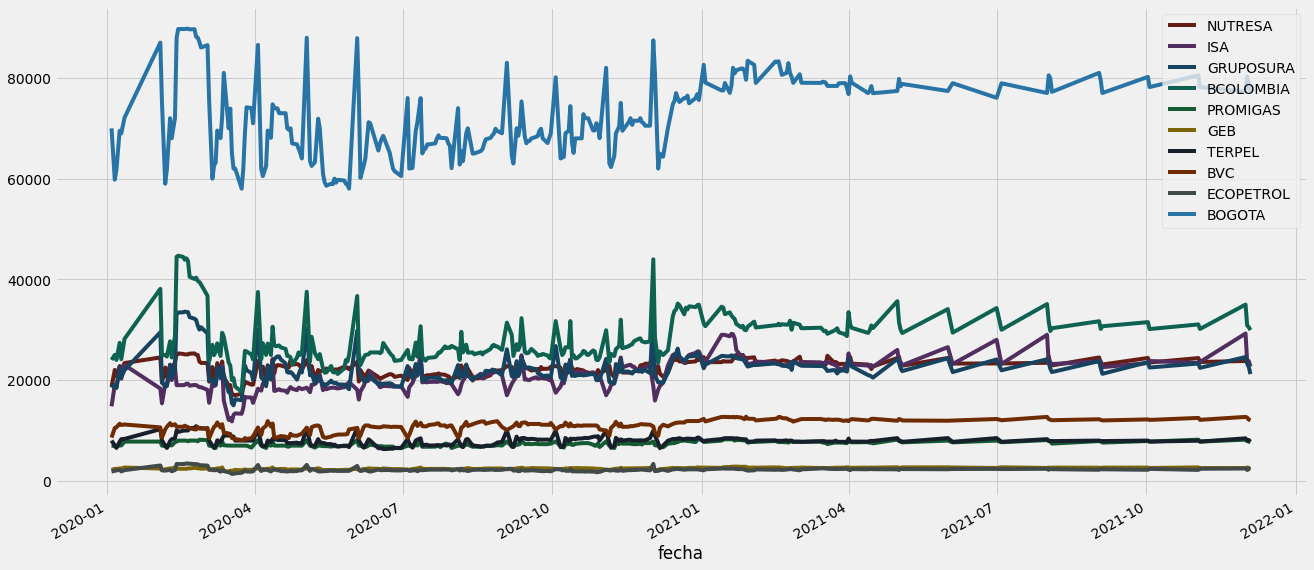

In [5]:
colores=['#641E16', '#512E5F', '#154360','#0E6251','#145A32','#7D6608','#17202A','#6E2C00','#424949','#2874A6']
datos.plot(figsize=(20,10), color=colores)

# Portafolio Optimo

Calculamos los retornos

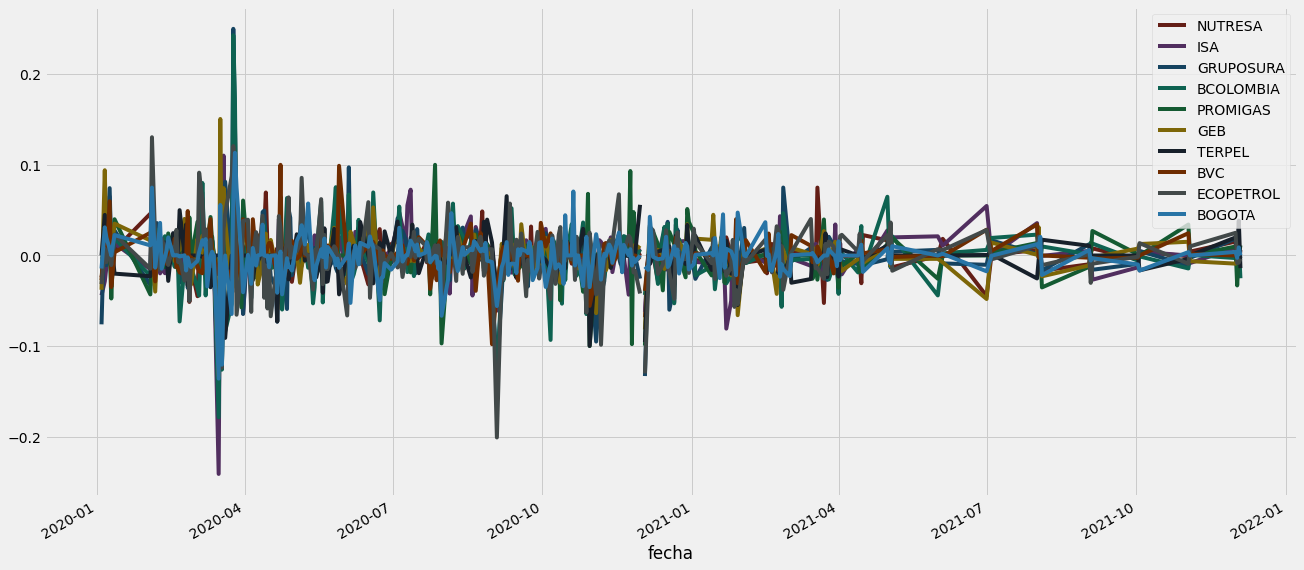

In [6]:
retornos=datos.pct_change()
retornos.plot(color=colores, figsize=(20,10))

**Covarianza y correlación de los retornos**

In [7]:
correlacion=retornos.corr()
covarianza=retornos.cov()

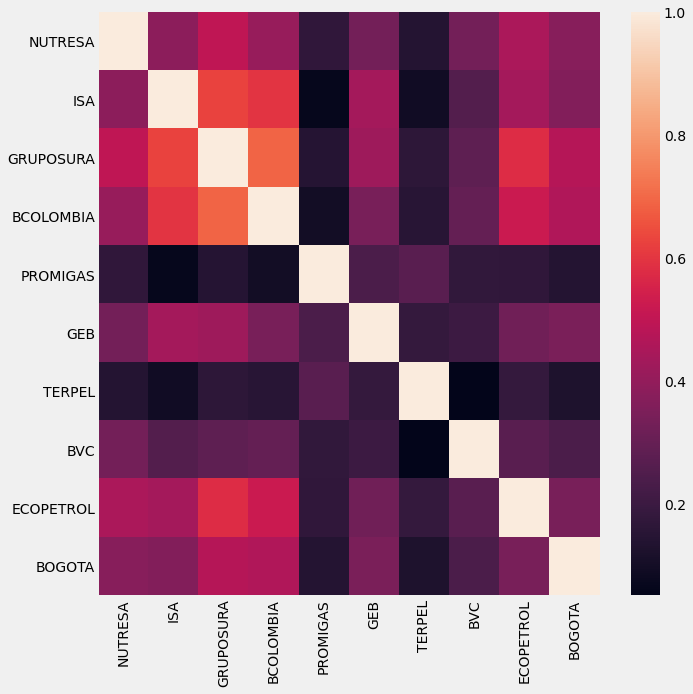

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(correlacion)

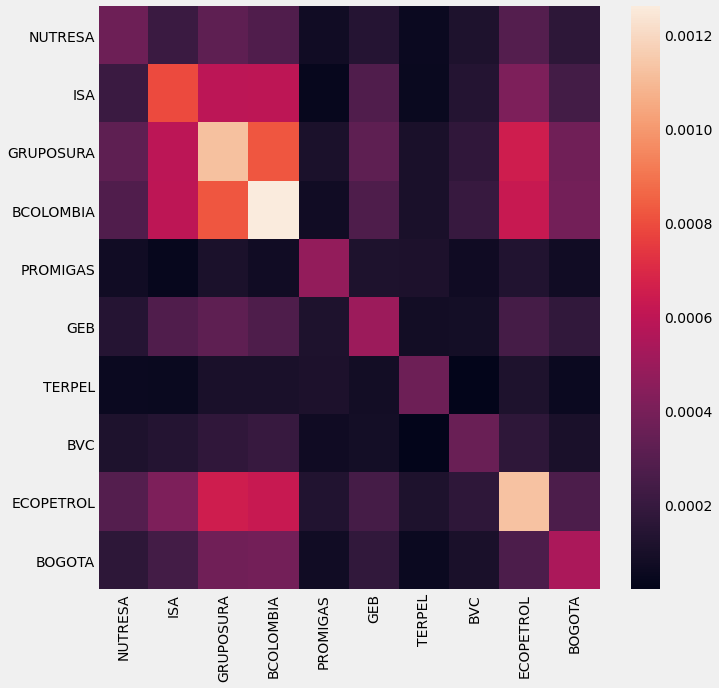

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(covarianza)

# Modelamiento

Rentabilidad esperada del protafolio:

$E(\mu)= \mu^T  w$

Riesgo del portafolio:

$S(\mu)=\sqrt{\mu^T  S + 2 (w^T cov)w}$

sto.

$\sum w_i = 1$

$0\le w_i$

$w_2 = 0.3$

In [8]:
mu=retornos.mean().values.reshape((10,1))
S=retornos.std().values.reshape((10,1))

In [10]:
w = cp.Variable(10)
riesgo=cp.sqrt(np.dot(mu.T,S)+2*cp.quad_form(w.T, covarianza.values))

In [11]:
prob = cp.Problem(cp.Minimize(riesgo), [cp.sum(w) == 1,  0 <= w, w[2]==0.3])

In [12]:
varesp=prob.solve(qcp=True)

In [13]:
pesos=w.value

# Aplicación

In [80]:
def generadorseries(ntiempo, tmuestra, datos):
  k=tmuestra-ntiempo
  xent=[]
  yent=[]
  for i in range(ntiempo,tmuestra):
    xent.append(datos[i-ntiempo:i,0])
    yent.append(datos[i,0])
  xent ,yent = np.array(xent),np.array(yent)
  xent=xent.reshape(k,ntiempo)
  return xent , yent

In [103]:
def mlp(x,y,n,opti, lost, act, epoch):
  modelo=Sequential()
  modelo.add(Dense(100, activation=act, input_shape=(n,)))
  modelo.add(Dense(1))
  modelo.compile(optimizer=opti, loss=lost)
  modelo.fit(x,y, epochs=epoch)
  return modelo.predict(x[-5:])


In [82]:
scaler=MinMaxScaler()

In [ ]:
data=scaler.fit_transform(datos.values)

In [ ]:
valor=[]
for j in range(data.shape[1]):
  x,y=generadorseries(11,286,data[:,j].reshape(286,1))
  yest=mlp(x,y,11, 'adam', 'mse', 'softmax', 2000)
  valor.append(yest)


In [ ]:
p=np.zeros(10)
l=0
for i in valor:
  p[l]=i[0][0]
  l+=1

In [ ]:
p=scaler.inverse_transform([p])

In [ ]:
p

array([[22262.80704737, 22980.32494783, 20715.57936072, 30808.38514566,
         7596.54499888,  2644.02163029,  7936.6779542 , 12256.70418739,
         2326.08723164, 77562.55344868]])

Cantidad de aciones a comprar el dia lunes, estaria dado por el modelo:

$$\max z = T $$
sto.
$\sum c_i \hat{p_i} \le N$

$\frac{\hat{p_i} c_i}{w_i} \ge  T \quad \forall i$

In [52]:
p=np.array([22262.80704737, 22980.32494783, 20715.57936072, 30808.38514566,
         7596.54499888,  2644.02163029,  7936.6779542 , 12256.70418739,
         2326.08723164, 77562.55344868])
p=np.round(p,0)

In [53]:
ji=(p/pesos.round(3))
# ji=ji.reshape((10,1))

In [54]:
di=np.eye(10)
for i in range(10):
  for j in range(10):
    if i==j:
      di[i][j]=ji[i]

In [55]:
T=cp.Variable(1) 
c=cp.Variable(10,integer=True)

In [56]:
objetivo=cp.Maximize(T)
inv=10000000

In [57]:
total=cp.scalar_product(p,c)
cant=di@c-T

In [58]:
model=cp.Problem(objetivo, [total<=inv,cant>=0])

In [59]:
model.solve()

9943974.358974358

In [62]:
cantidad=c.value

*Valor del portafolio en el tiempo*

In [77]:
cantidad=cantidad.reshape((10,1))

In [78]:
datos2=datos.dot(cantidad)

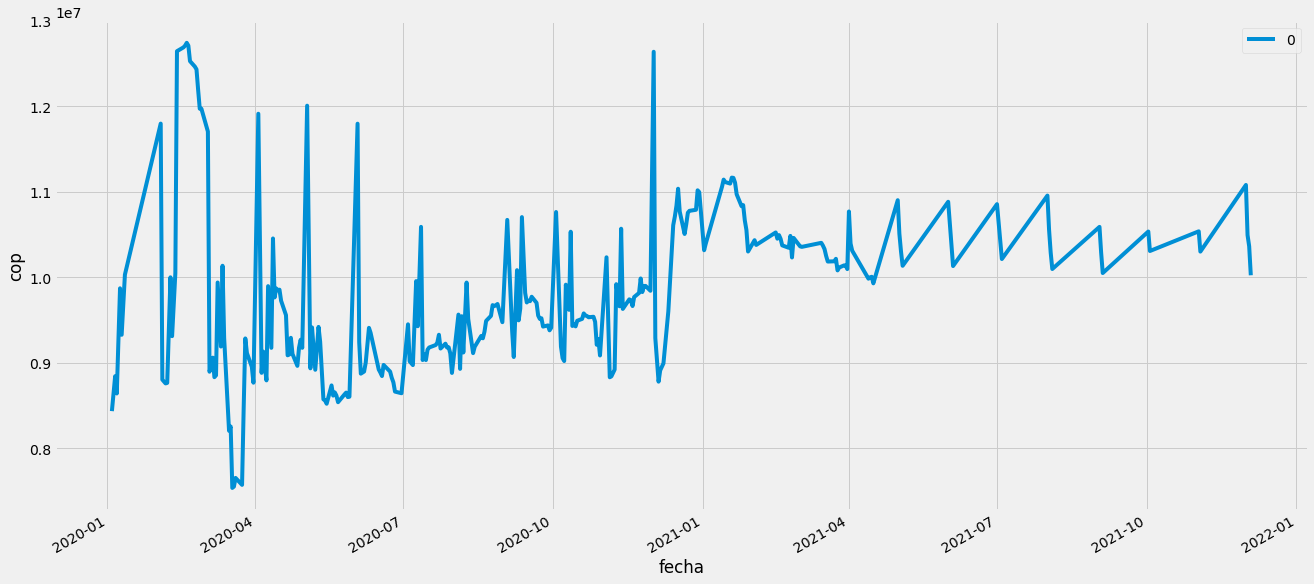

In [79]:
datos2.plot(figsize=(20,10), ylabel='cop')

In [83]:
dtos2=scaler.fit_transform(datos2)

In [87]:
x,y=generadorseries(11,286,dtos2)

In [ ]:
yestimada=mlp(x,y,11, 'adam', 'mse', 'softmax', 1500)

In [104]:
fcha=np.arange('2021-04-19','2021-04-24', dtype=np.datetime64)

In [106]:
yestimada=scaler.inverse_transform(yestimada)

In [108]:
resultado=pd.DataFrame(yestimada,index=fcha, columns=['Pronostico'])

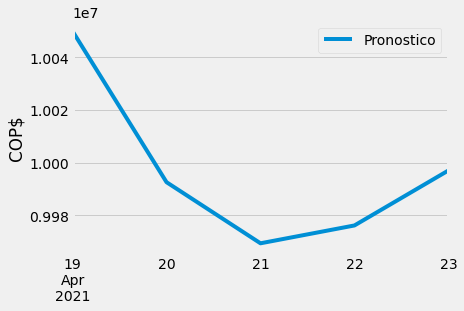

In [110]:
resultado.plot(ylabel='COP$')